# Titanic Survival: Advanced Classification Techniques

In the _titanic-simple-logreg.ipynb_ notebook, I used simple Logistic Regression for this classification task. The LogReg model placed _13873/16479_, so not great...! 
In this notebook I will experiment with somewhat more sophisticated algorithms for the classification task. In no particular order, these would be 
* Logistic Regression
* Support Vector Machines
* Dense Neural Networks, or Multi-layers perceptrons 
* XGBoost Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
%xmode minimal

Exception reporting mode: Minimal


In [2]:
def save_submission(fname, predictions, ids):
    with open(fname, "w") as f:
        f.write("PassengerId,Survived\n")
        for idx, pred in zip(ids, predictions):
            f.write(f"{idx},{pred}\n")


In [3]:
## read in the data: train and test sets.
path = Path("/Users/rmyazdi/Documents/kaggle/titanic")
train = pd.read_csv(path/ "data" / "train.csv")
test = pd.read_csv(path / "data" / "test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
Y_true = train.Survived.copy()
train = train.drop("Survived", inplace=False, axis=1)

In [6]:
total = pd.concat([train, test], ignore_index=True, axis=0)

In [7]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


In [8]:
train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Now, need to do some data cleaning and pruning:
1. The Name, ticket and Cabin fields don't provide any information. 
2. Sex should be converted to an integer: 0 --> Male, 1 --> Female
3. Age: impute nans by the average
4. Embarked: impute nans by the most common
5. Add a new feature: TotalAccom = SibSp + Parch

In [9]:
total.Embarked.value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [10]:
## drop useless columns
total.drop(["Cabin","Name","Ticket"], inplace=True, axis=1)
## calculate the mean for Age on the train set
mean_age = train.Age.mean()
total.Age.where(pd.notna(total.Age), mean_age, inplace=True)
std_age = train.Age.std()
total.Age = (total.Age-mean_age)/std_age
## Embarkation: compute mode on the train set
most_common_embarkation_port = train.Embarked.mode()[0]
total.Embarked.where(pd.notna(total.Embarked), most_common_embarkation_port, inplace=True)
## Embarkation: one-hot-encode:
embarked_counts = total.Embarked.value_counts()
for i, port in enumerate(embarked_counts):
    total[f"Embarked_{i}"] = np.where(total.Embarked == port, 1, 0)
## now drop the Embarked column itself
total.pop("Embarked")
## Add new feature:
total["TotalAccom"] = total.Parch + total.SibSp
total["DiffAccom"]  = total.Parch**2 - total.SibSp**2
#total["RatioAccom"] = total.Parch / (total.SibSp + 1.0)
train_tot = total.Parch**2 + total.SibSp**2
train_diff = total.Parch**2 - total.SibSp**2
#train_ratio = total.Parch / (total.SibSp + 1.0)

tot_accom_mean, tot_accom_std = train_tot.mean(), train_tot.std()
diff_accom_mean, diff_accom_std = train_diff.mean(), train_diff.std()
#ratio_accom_mean, ratio_accom_std = train_ratio.mean(), train_ratio.std()

total.TotalAccom = (total.TotalAccom - tot_accom_mean)/tot_accom_std
total.DiffAccom  = (total.DiffAccom - diff_accom_mean)/diff_accom_std
#total.RatioAccom = (total.RatioAccom - ratio_accom_mean)/ratio_accom_std

## convert the _Sex_ column to a single column of 0 or 1
total.Sex = np.where(total.Sex == "male", 0, 1)
## convert the class parameter to 1/class: since we have 1 < 2 < 3 while first class is 
## perhaps more likely to have survived and is a better position, so it should be 1 > 2 > 3
total.Pclass = 1./total.Pclass
fare_mean, fare_std = train.Fare.mean(), train.Fare.std()
total.Fare.fillna(fare_mean, inplace=True)
total.Fare = (total.Fare - fare_mean)/fare_std
total["FareAndSex"] = total.Fare * total.Sex



In [11]:
train_clean = total.iloc[:len(train), :]
test_clean  = total.iloc[len(train): , :]

In [12]:
train_clean.shape, train.shape, test_clean.shape, test.shape

((891, 13), (891, 11), (418, 13), (418, 11))

Now we are ready to start the modelling. But first, let's plot the stuff that we have.

In [13]:
train_clean["Survived"] = Y_true
train_clean.set_index("PassengerId", inplace=True)
test_clean.set_index("PassengerId", inplace=True)

In [14]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    float64
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked_0  891 non-null    int64  
 7   Embarked_1  891 non-null    int64  
 8   Embarked_2  891 non-null    int64  
 9   TotalAccom  891 non-null    float64
 10  DiffAccom   891 non-null    float64
 11  FareAndSex  891 non-null    float64
 12  Survived    891 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 97.5 KB


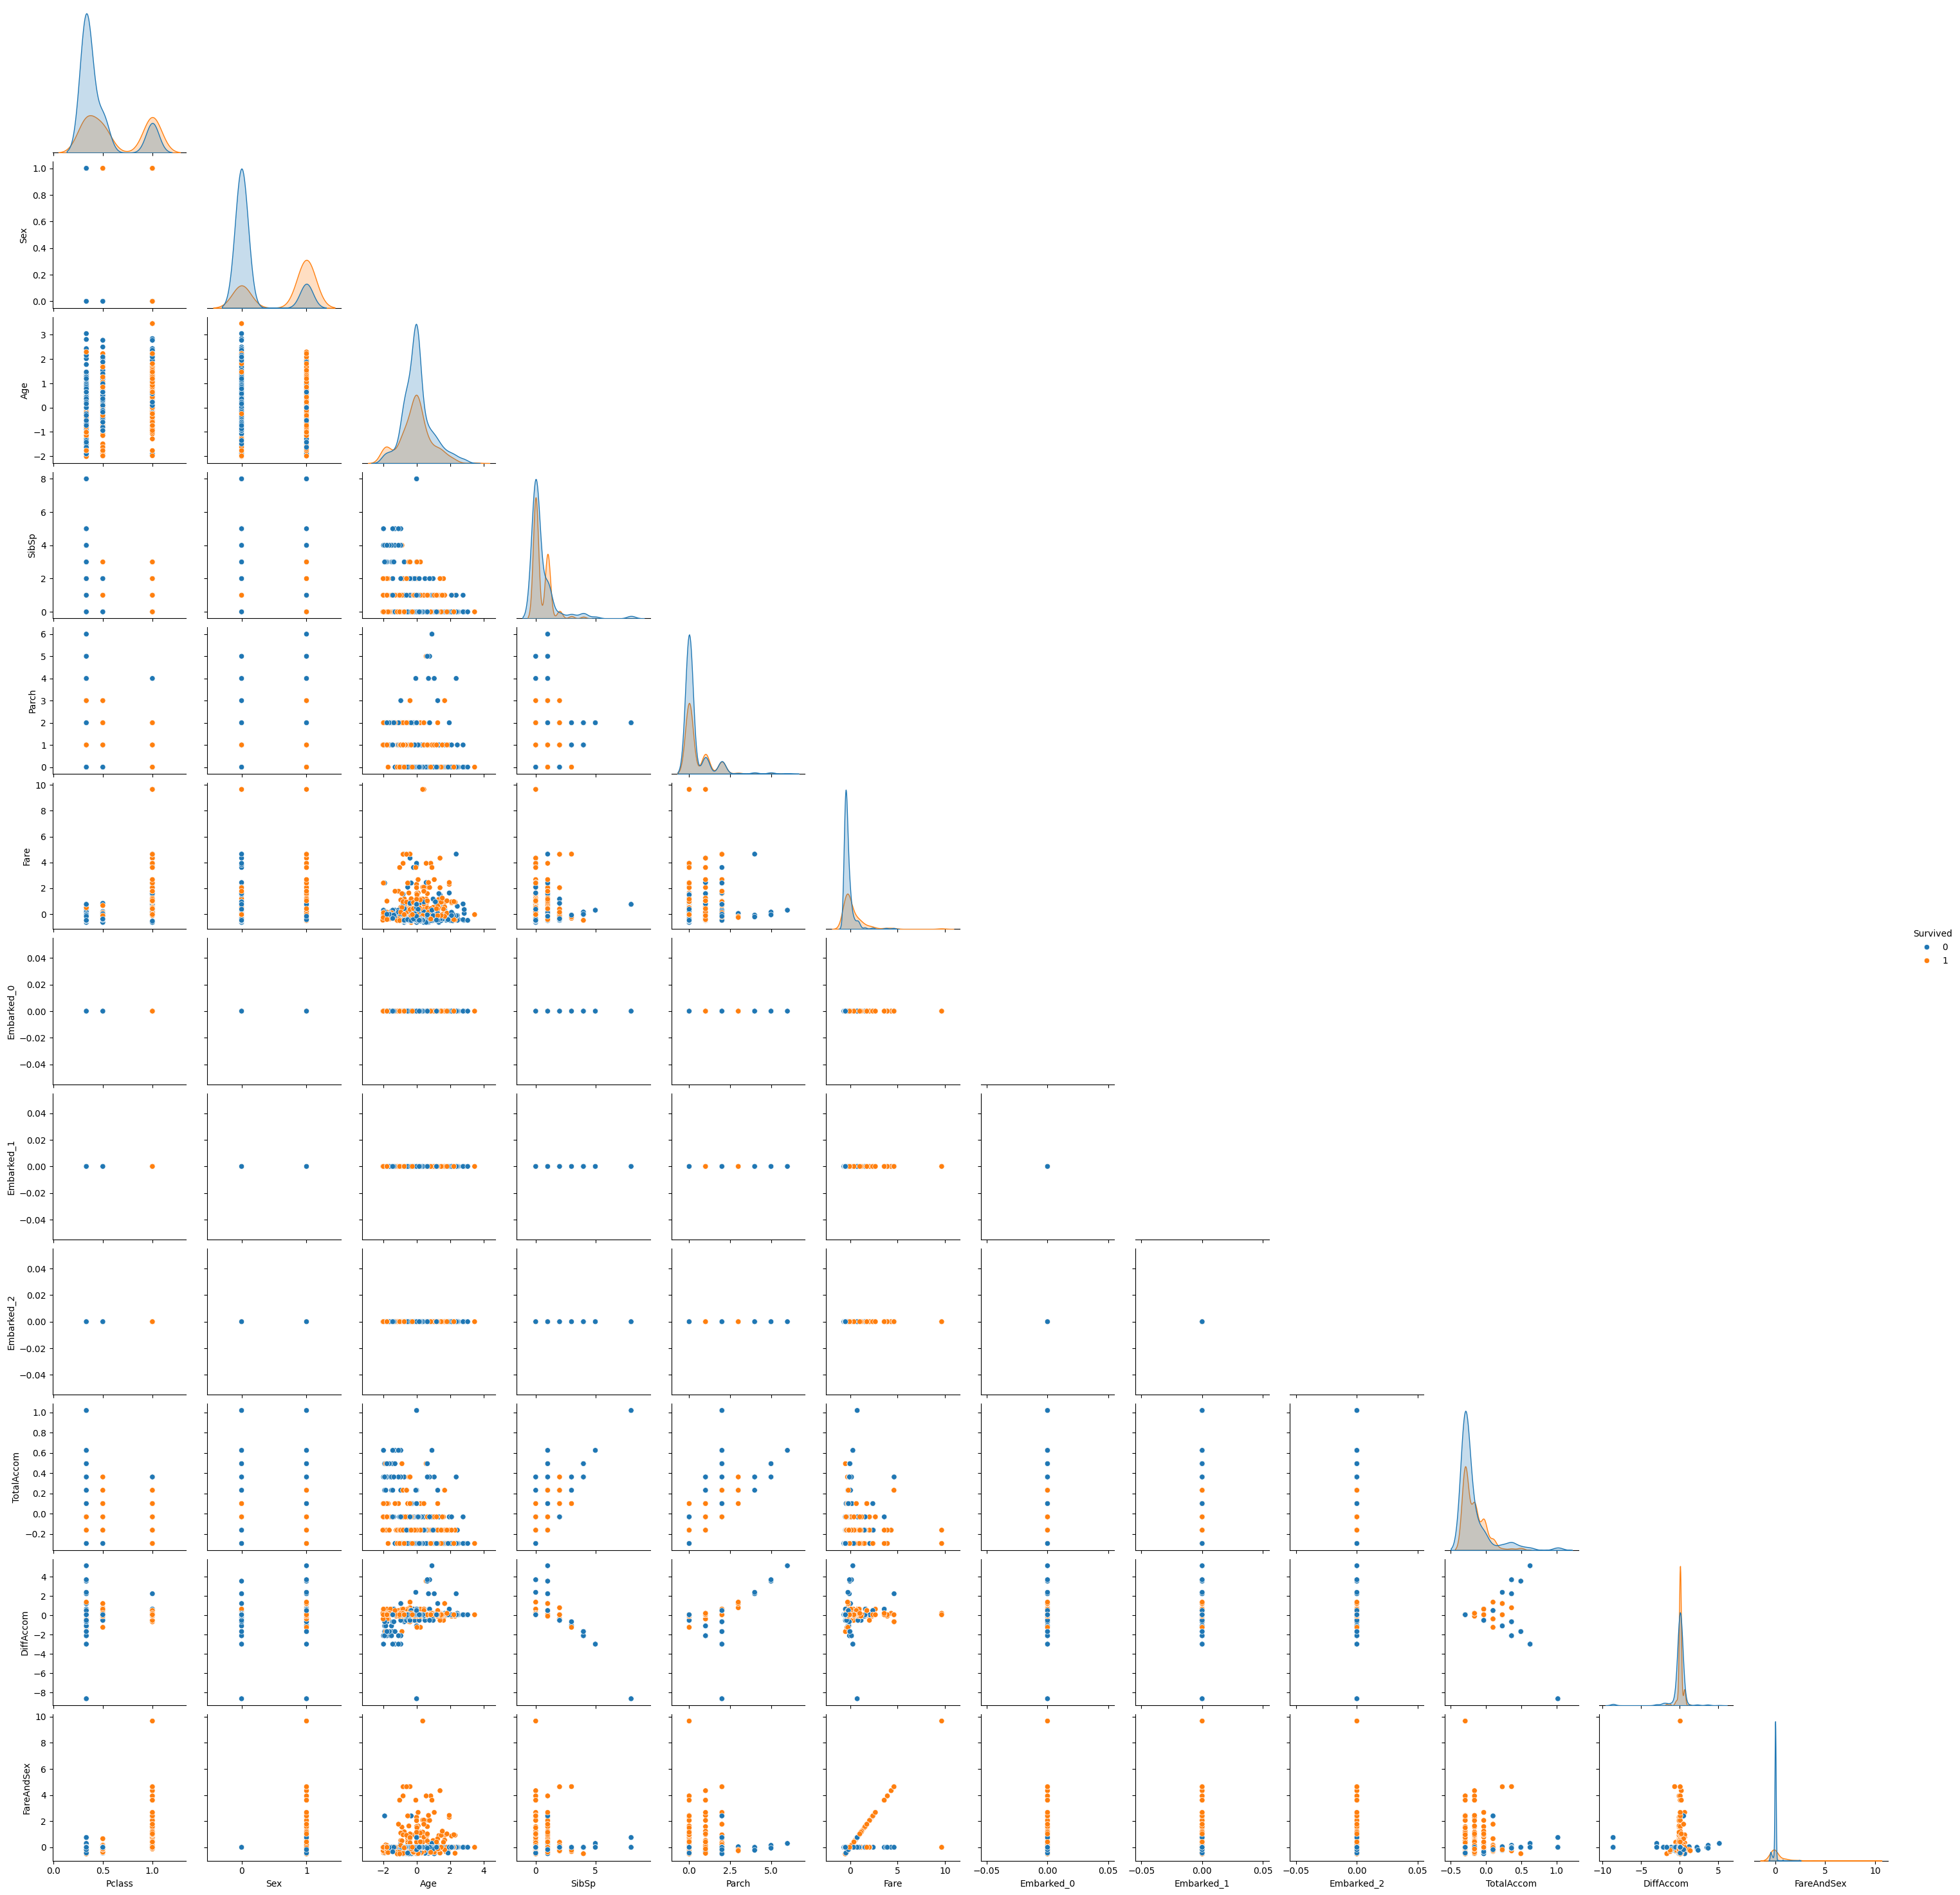

In [15]:
sns.pairplot(data=train_clean, corner=True, hue="Survived")

In [16]:
train_clean.drop("Survived", axis=1, inplace=True)
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    float64
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked_0  891 non-null    int64  
 7   Embarked_1  891 non-null    int64  
 8   Embarked_2  891 non-null    int64  
 9   TotalAccom  891 non-null    float64
 10  DiffAccom   891 non-null    float64
 11  FareAndSex  891 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 90.5 KB


In [17]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    float64
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4   Parch       418 non-null    int64  
 5   Fare        418 non-null    float64
 6   Embarked_0  418 non-null    int64  
 7   Embarked_1  418 non-null    int64  
 8   Embarked_2  418 non-null    int64  
 9   TotalAccom  418 non-null    float64
 10  DiffAccom   418 non-null    float64
 11  FareAndSex  418 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 42.5 KB


Now let's do some model building. I'll still keep it simple here, begining with a LogisticRegression analysis.

In [18]:
model_1 = LogisticRegression(penalty = "l2", solver="newton-cholesky")
model_1.fit(X=train_clean, y=Y_true)
predictions = model_1.predict(X=test_clean)
save_fname = path / "submissions" / "submission_logreg.csv"
save_fname.touch()

save_submission(save_fname, predictions, test_clean.index)


In [19]:
model_2 = svm.LinearSVC(max_iter=100000)
model_2.fit(train_clean, Y_true)
predictions = model_2.predict(X=test_clean)
save_fname = path / "submissions" / "submission_linearSVC.csv"
save_fname.touch()

save_submission(save_fname, predictions, test_clean.index)


In [20]:
model_3 = svm.SVC(kernel="rbf", max_iter=-1, gamma="auto")
model_3.fit(train_clean, Y_true)
predictions = model_3.predict(X=test_clean)
save_fname = path / "submissions" / "submission_SVC.csv"
save_fname.touch()

save_submission(save_fname, predictions, test_clean.index)


In [21]:

model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(units=4, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

learning = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr : 0.001, verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)

model_4.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

model_4.fit(train_clean, Y_true, epochs=200, callbacks=[early_stopping, learning], verbose=0, validation_split=0.25, batch_size=1024)


predictions = model_4.predict(test_clean)
predictions = [0 if x < 0.5 else 1 for x in predictions]

save_fname = path / "submissions" / "submission_DenseNN.csv"
save_fname.touch()

save_submission(save_fname, predictions, test_clean.index)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [44]:
param_grid_RBF = {"kernel": [RBF(length_scale=l) for l in np.logspace(-2, -1, 4)]}
param_grid_dot = {"kernel" : [DotProduct(sigma_0=s) for s in np.logspace(-2, -1, 4)]}
param_grid_matern = {"kernel": [Matern(length_scale=0.1, nu=n) for n in [0.5, 1.5, 2.5, 3.5]]}

param_grids = {"RBF": param_grid_RBF, "Dot":param_grid_dot, "matern":param_grid_matern}
gridsearches = {}
for kernel in param_grids:
    pgrid = param_grids[kernel]
    print(kernel)
    gridsearch = GridSearchCV(estimator=GaussianProcessClassifier(random_state=0), 
                              param_grid=pgrid, cv=5, scoring="accuracy", verbose=4)
    gridsearch.fit(train_clean, Y_true)
    gridsearches[kernel] = gridsearch

RBF
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......kernel=RBF(length_scale=0.1);, score=0.804 total time=  31.6s
[CV 2/5] END ......kernel=RBF(length_scale=0.1);, score=0.820 total time=  27.1s
[CV 3/5] END ......kernel=RBF(length_scale=0.1);, score=0.809 total time=  26.9s
[CV 4/5] END ......kernel=RBF(length_scale=0.1);, score=0.809 total time=  24.7s
[CV 5/5] END ......kernel=RBF(length_scale=0.1);, score=0.854 total time=  27.0s
[CV 1/5] END ....kernel=RBF(length_scale=0.316);, score=0.804 total time=  24.9s
[CV 2/5] END ....kernel=RBF(length_scale=0.316);, score=0.820 total time=  21.9s
[CV 3/5] END ....kernel=RBF(length_scale=0.316);, score=0.809 total time=  16.6s
[CV 4/5] END ....kernel=RBF(length_scale=0.316);, score=0.809 total time=  19.4s
[CV 5/5] END ....kernel=RBF(length_scale=0.316);, score=0.854 total time=  19.6s
[CV 1/5] END ........kernel=RBF(length_scale=1);, score=0.804 total time=  19.4s
[CV 2/5] END ........kernel=RBF(length_scale=

In [45]:
for kernel in gridsearches:
    gs = gridsearches[kernel]
    print(f"{kernel} --> {gs.best_score_}, {gs.best_estimator_.get_params()}")

RBF --> 0.8193208210407382, {'copy_X_train': True, 'kernel__length_scale': 0.1, 'kernel__length_scale_bounds': (1e-05, 100000.0), 'kernel': RBF(length_scale=0.1), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 0, 'warm_start': False}
Dot --> 0.786761659657272, {'copy_X_train': True, 'kernel__sigma_0': 0.1, 'kernel__sigma_0_bounds': (1e-05, 100000.0), 'kernel': DotProduct(sigma_0=0.1), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 0, 'warm_start': False}
matern --> 0.8181972255351203, {'copy_X_train': True, 'kernel__length_scale': 0.1, 'kernel__length_scale_bounds': (1e-05, 100000.0), 'kernel__nu': 2.5, 'kernel': Matern(length_scale=0.1, nu=2.5), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 0, 'war

In [ ]:

predictions = best_model_5.predict(test_clean)

save_fname = path / "submissions" / "submission_GPC_RBF.csv"
save_fname.touch()

save_submission(save_fname, predictions, test_clean.index)

In [50]:
np.logspace(-2, 0, 6)

array([0.01      , 0.02511886, 0.06309573, 0.15848932, 0.39810717,
       1.        ])